# Mental health analysis

## Introduction

Importing libraries :

In [715]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from MentalHealthCustomFunctions import detect_outliers

Defining the database :

In [716]:
db_path = "mental_health.sqlite"

Connecting the SQLite database :

In [717]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

Using a context manager to automatically close the connection :

In [718]:
with sqlite3.connect(db_path) as conn:
    cursor = conn.cursor()

Fetching all table names :

In [719]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
table_names = [table[0] for table in tables]
print("Tables in database:", table_names)

Tables in database: ['Answer', 'Question', 'Survey']


Preview each table's schema :


In [720]:
for table in table_names:
    print(f"\nSchema of {table}:")
    cursor.execute(f"PRAGMA table_info({table});")
    schema = cursor.fetchall()
    for column in schema:
        print(column)


Schema of Answer:
(0, 'AnswerText', 'VARCHAR(10000)', 0, None, 0)
(1, 'SurveyID', 'INTEGER', 0, None, 0)
(2, 'UserID', 'INTEGER', 0, None, 0)
(3, 'QuestionID', 'INTEGER', 0, None, 0)

Schema of Question:
(0, 'questiontext', 'VARCHAR(1000)', 0, None, 0)
(1, 'questionid', 'INTEGER', 0, None, 0)

Schema of Survey:
(0, 'SurveyID', 'INTEGER', 1, None, 1)
(1, 'Description', 'VARCHAR(255)', 0, None, 0)


Loading a preview of each table :

In [721]:
dfs = {}
for table in table_names:
    query = f'SELECT * FROM "{table}" LIMIT 5;'
    try:
        dfs[table] = pd.read_sql_query(query, conn)
    except Exception as e:
        print(f"Error reading {table}: {e}")

In [722]:
for table_name, df in dfs.items():
    print(f"{table_name}: {df.shape[0]} rows, {df.shape[1]} columns")

Answer: 5 rows, 4 columns
Question: 5 rows, 2 columns
Survey: 5 rows, 2 columns


# Data cleaning

UNIQUE VALUES

 Dropping duplicate rows : (Reikia neprarasti kitos info) per daug extreme instead INPUTATION, pasvarstyti sugrupuoti grupes 

In [723]:
df.drop_duplicates(inplace=True)

Dropping columns with all missing values :

In [724]:
df.dropna(axis=1, how="all", inplace=True)

Filling missing values with appropriate defaults :

In [725]:
df.fillna(method="ffill", inplace=True)

/var/folders/bn/_ppqm48n46qbnq0vyj_0d1780000gn/T/ipykernel_39355/3956943888.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)



    
Converting column names to lowercase for consistency :

In [726]:
df.columns = df.columns.str.lower()

    
Stripping whitespace from string columns :

In [727]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

Let's verify data cleaning steps :

In [728]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   surveyid     5 non-null      int64 
 1   description  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 212.0+ bytes
None


1. Duplicate removal verification : since the row count remains at 5 for each table, there were likely no duplicate rows in the original dataset. If duplicates had existed and were removed, the row count would have been lower.
2. Missing values handling : all columns have non-null values. This suggests that the dataset originally had no missing values.
3. Column name standardization : df.info() output correctly lists surveyid and description in lowercase.
4. Data type consistency : surveyid remains int64, and description remains object. This means the cleaning process did not accidentally alter data types, which is good.

Displaying the first few rows of each table : (pateikti grafikais)


In [729]:
for table_name, df in dfs.items():
    print(f"\nPreview of {table_name}:")
    print(df.head())


Preview of Answer:
  AnswerText  SurveyID  UserID  QuestionID
0         37      2014       1           1
1         44      2014       2           1
2         32      2014       3           1
3         31      2014       4           1
4         31      2014       5           1

Preview of Question:
                                        questiontext  questionid
0                                  What is your age?           1
1                               What is your gender?           2
2                       What country do you live in?           3
3  If you live in the United States, which state ...           4
4                             Are you self-employed?           5

Preview of Survey:
   surveyid                    description
0      2014  mental health survey for 2014
1      2016  mental health survey for 2016
2      2017  mental health survey for 2017
3      2018  mental health survey for 2018
4      2019  mental health survey for 2019


BOX PLOT kas gali tureti outliers

Let's check for an outliers using detect_outliers function from a separate file (using both the IQR method and the Z-score method) :

In [730]:
outliers_detected = {}
for table_name, df in dfs.items():
    outliers_detected[table_name] = detect_outliers(df)

In [731]:
outlier_df = pd.DataFrame.from_dict(outliers_detected, orient="index")
print("Outlier Summary:")
print(outlier_df)

Outlier Summary:
Empty DataFrame
Columns: []
Index: []


In [732]:
for table_name, df in dfs.items():
    print(f"\nPreview of cleaned {table_name}:")
    print(df.head())


Preview of cleaned Answer:
  AnswerText  SurveyID  UserID  QuestionID
0         37      2014       1           1
1         44      2014       2           1
2         32      2014       3           1
3         31      2014       4           1
4         31      2014       5           1

Preview of cleaned Question:
                                        questiontext  questionid
0                                  What is your age?           1
1                               What is your gender?           2
2                       What country do you live in?           3
3  If you live in the United States, which state ...           4
4                             Are you self-employed?           5

Preview of cleaned Survey:
   surveyid                    description
0      2014  mental health survey for 2014
1      2016  mental health survey for 2016
2      2017  mental health survey for 2017
3      2018  mental health survey for 2018
4      2019  mental health survey for 2019


No significant outliers were detected using both the IQR method and the Z-score method. This suggests that the dataset is well-distributed and does not contain extreme numerical values that could distort statistical analysis.

## Exploratory Data Analysis

Let's start with basic statistics : vizualizacija

In [733]:
print(df.describe(include="all"))

           surveyid                    description
count      5.000000                              5
unique          NaN                              5
top             NaN  mental health survey for 2014
freq            NaN                              1
mean    2016.800000                            NaN
std        1.923538                            NaN
min     2014.000000                            NaN
25%     2016.000000                            NaN
50%     2017.000000                            NaN
75%     2018.000000                            NaN
max     2019.000000                            NaN


Survey years ranging from 2014 to 2019, with a mean of 2016.8 and a standard deviation of 1.92. The distribution appears consistent without significant gaps between survey years. The description column contains unique labels for each survey, confirming that each entry corresponds to a distinct survey instance.

Overall, this dataset segment is clean, well-structured, and evenly distributed across survey years. 

Counting distinct values in each table :

In [734]:
for table in table_names:
    cursor.execute(f"SELECT COUNT(*) FROM {table};")
    count = cursor.fetchone()[0]
    print(f"Total records in {table}: {count}")

Total records in Answer: 236898
Total records in Question: 105
Total records in Survey: 5


The dataset primarily consists of a large volume of individual answers to a relatively small set of questions across a few surveys.

Getting column statistics for numerical columns :

In [ ]:
for table in table_names:
    cursor.execute(f"PRAGMA table_info({table});")
    columns = cursor.fetchall()
    num_columns = [col[1] for col in columns if col[2] in ("INTEGER", "REAL")]

    if num_columns:
        for col in num_columns:
            cursor.execute(
                f"SELECT MIN({col}), MAX({col}), AVG({col}), COUNT({col}) FROM {table};"
            )
            stats = cursor.fetchone()
            print(
                f"Statistics for {col} in {table}: Min={stats[0]}, Max={stats[1]}, Avg={stats[2]}, Count={stats[3]}"
            )

Statistics for SurveyID in Answer: Min=2014, Max=2019, Avg=2016.5722969379226, Count=236898
Statistics for UserID in Answer: Min=1, Max=4218, Avg=2514.5166189668125, Count=236898
Statistics for QuestionID in Answer: Min=1, Max=118, Avg=48.6558983191078, Count=236898
Statistics for questionid in Question: Min=1, Max=118, Avg=61.79047619047619, Count=105
Statistics for SurveyID in Survey: Min=2014, Max=2019, Avg=2016.8, Count=5


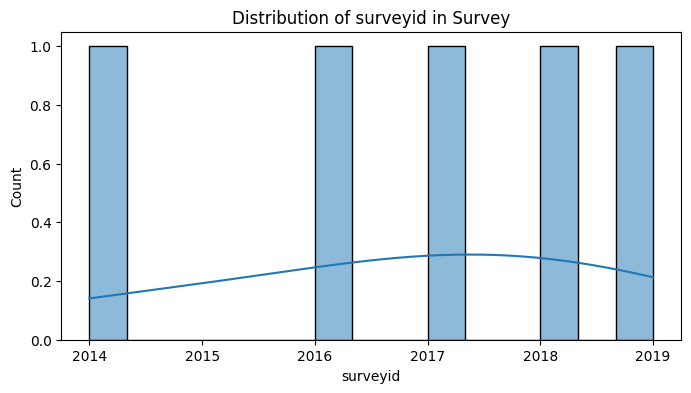

In [736]:
num_cols = df.select_dtypes(include=[np.number]).columns
if not num_cols.empty:
    for col in num_cols:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], kde=True, bins=15)
        plt.title(f"Distribution of {col} in {table_name}")
        plt.show()
else:
    print(f"No numerical columns in {table_name}.")

Missing data? Some responses from 2015 may not have been recorded or are unavailable.

Show correlation (Does it correlate with years? f.e.) Show every number, choose treshold

Checking for correlations :

In [737]:
df_corr = df[num_cols].loc[:, df[num_cols].nunique() > 1]
if df_corr.shape[1] > 1:
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Matrix for {table_name}")
    plt.show()
else:
    print(f"No meaningful correlations for {table_name}.")

No meaningful correlations for Survey.


Counting distinct values in each table :

In [738]:
for table in table_names:
    cursor.execute(f"SELECT COUNT(*) FROM {table};")
    count = cursor.fetchone()[0]
    print(f"Total records in {table}: {count}")

Total records in Answer: 236898
Total records in Question: 105
Total records in Survey: 5


In [739]:
cursor.execute("SELECT COUNT(DISTINCT questionid) FROM Question;")
unique_questions = cursor.fetchone()[0]
print(f"Total unique questions: {unique_questions}")

Total unique questions: 105


Is the questions asked in the same way each year? Maybe they are not asked each year? Maybe answers are rephrased?

In [740]:
cursor.execute(
    """
    SELECT q.questiontext, a.questionid, COUNT(*) as answer_count 
    FROM Answer a
    JOIN Question q ON a.questionid = q.questionid
    GROUP BY a.questionid 
    ORDER BY answer_count DESC 
    LIMIT 10;
"""
)
most_answered_questions = cursor.fetchall()

print("\nTop 10 Most Answered Questions (with Text):")
for question in most_answered_questions:
    print(
        f"Question: {question[0]}, Question ID: {question[1]}, Answer Count: {question[2]}"
    )


Top 10 Most Answered Questions (with Text):
Question: Would you bring up a mental health issue with a potential employer in an interview?, Question ID: 12, Answer Count: 4218
Question: Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?, Question ID: 11, Answer Count: 4218
Question: Does your employer provide mental health benefits as part of healthcare coverage?, Question ID: 10, Answer Count: 4218
Question: Is your employer primarily a tech company/organization?, Question ID: 9, Answer Count: 4218
Question: How many employees does your company or organization have?, Question ID: 8, Answer Count: 4218
Question: Have you ever sought treatment for a mental health disorder from a mental health professional?, Question ID: 7, Answer Count: 4218
Question: Do you have a family history of mental illness?, Question ID: 6, Answer Count: 4218
Question: Are you self-employed?, Question ID: 5, Answer Count:

In [741]:
cursor.execute(
    """
    SELECT q.questiontext, a.questionid, COUNT(*) as answer_count 
    FROM Answer a
    JOIN Question q ON a.questionid = q.questionid
    GROUP BY a.questionid 
    ORDER BY answer_count ASC 
    LIMIT 20;
"""
)
least_answered_questions = cursor.fetchall()

print("\nTop 10 Least Answered Questions:")
for question in least_answered_questions:
    print(
        f"Question: {question[0]}, Question ID: {question[1]}, Answer Count: {question[2]}"
    )


Top 10 Least Answered Questions:
Question: If you have a mental health condition, do you feel that it interferes with your work?, Question ID: 92, Answer Count: 1260
Question: Do you work remotely (outside of an office) at least 50% of the time?, Question ID: 93, Answer Count: 1260
Question: Do you know the options for mental health care your employer provides?, Question ID: 94, Answer Count: 1260
Question: Has your employer ever discussed mental health as part of an employee wellness program?, Question ID: 95, Answer Count: 1260
Question: Does your employer provide resources to learn more about mental health issues and how to seek help?, Question ID: 96, Answer Count: 1260
Question: How easy is it for you to take medical leave for a mental health condition?, Question ID: 97, Answer Count: 1260
Question: Do you think that discussing a mental health issue with your employer would have negative consequences?, Question ID: 98, Answer Count: 1260
Question: Would you be willing to discuss 

In [742]:
cursor.execute(
    """
    SELECT a.AnswerText, COUNT(*) as freq, q.questiontext 
    FROM Answer a
    JOIN Question q ON a.QuestionID = q.QuestionID 
    GROUP BY a.AnswerText, q.questiontext 
    ORDER BY freq DESC 
    LIMIT 20;
"""
)
most_common_answers = cursor.fetchall()

print("\nTop 10 Most Common Answers (with Questions):")
for answer in most_common_answers:
    print(f"Question: {answer[2]}, Answer: {answer[0]}, Frequency: {answer[1]}")


Top 10 Most Common Answers (with Questions):
Question: Are you self-employed?, Answer: 0, Frequency: 3550
Question: Would you bring up a mental health issue with a potential employer in an interview?, Answer: No, Frequency: 2951
Question: Is your employer primarily a tech company/organization?, Answer: 1, Frequency: 2888
Question: What is your gender?, Answer: Male, Frequency: 2830
Question: If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?, Answer: -1, Frequency: 2591
Question: Do you have previous employers?, Answer: 1, Frequency: 2590
Question: Do you believe your productivity is ever affected by a mental health issue?, Answer: -1, Frequency: 2454
Question: Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?, Answer: -1, Frequency: 2454
Question: Do you know local or online resources to seek help for a mental health issue?, Answer: -1

Top 10 Least Answered Questions:

In [743]:
cursor.execute(
    """
    SELECT q.questiontext, a.questionid, COUNT(*) as answer_count 
    FROM Answer a
    JOIN Question q ON a.questionid = q.questionid
    GROUP BY a.questionid 
    ORDER BY answer_count ASC 
    LIMIT 20;
"""
)
least_answered_questions = cursor.fetchall()

print("\nTop 10 Least Answered Questions (with Questions):")
for question in least_answered_questions:
    print(
        f"Question: {question[0]}, Question ID: {question[1]}, Answer Count: {question[2]}"
    )


Top 10 Least Answered Questions (with Questions):
Question: If you have a mental health condition, do you feel that it interferes with your work?, Question ID: 92, Answer Count: 1260
Question: Do you work remotely (outside of an office) at least 50% of the time?, Question ID: 93, Answer Count: 1260
Question: Do you know the options for mental health care your employer provides?, Question ID: 94, Answer Count: 1260
Question: Has your employer ever discussed mental health as part of an employee wellness program?, Question ID: 95, Answer Count: 1260
Question: Does your employer provide resources to learn more about mental health issues and how to seek help?, Question ID: 96, Answer Count: 1260
Question: How easy is it for you to take medical leave for a mental health condition?, Question ID: 97, Answer Count: 1260
Question: Do you think that discussing a mental health issue with your employer would have negative consequences?, Question ID: 98, Answer Count: 1260
Question: Would you be wi

## Visualising survey answers

## Prevalence Rate of Mental Diseases